In [1]:
import numpy as np 
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import importlib
import json

import sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

importlib.reload(group_postprocess)
importlib.reload(run_sampler)

/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/utils/io.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


<module 'time_domain_gw_inference.run_sampler' from '/mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/run_sampler.py'>

### Load likelihood manager

In [2]:
 # Get likelihood manager
data = group_postprocess.load_run_settings_from_directory('./output/250617_output', filename_dict={'full':'full_0.0seconds'})
lm = data['runs']['full']['likelihood_manager']

key: full
line is /mnt/home/smiller/src/time-domain-gw-inference/time_domain_gw_inference/run_sampler.py --output-h5 full_0.0seconds/full_0.0seconds.h5 --mode full --Tcut-seconds 0.0 --ifos H1 L1 V1 --total-mass-prior-bounds 30 70 --mass-ratio-prior-bounds 0.125 1 --time-prior-sigma 0.02 --luminosity-distance-prior-bounds 100 300 --approx IMRPhenomXPHM --ncpu 32 --nsteps 50000 --Tstart 1238175798.5930877 --Tend 1238175800.2930877 --sampling-rate 4096 --f22-start 10 --fref 20 --flow 20 --fmax 1024 --vary-skypos  --vary-time  --resume  --reference-parameters data_directory/injection.json --data H1:data_directory/H1_strain.h5 --data L1:data_directory/L1_strain.h5 --data V1:data_directory/V1_strain.h5 --psd H1:data_directory/H1_PSD.txt --psd L1:data_directory/L1_PSD.txt --psd V1:data_directory/V1_PSD.txt  &>> full_0.0seconds/full_0.0seconds.log

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
reference_parameters are {'chirp_mass': 17.05154497989469, 'mass_ratio': 

### Plot PSD

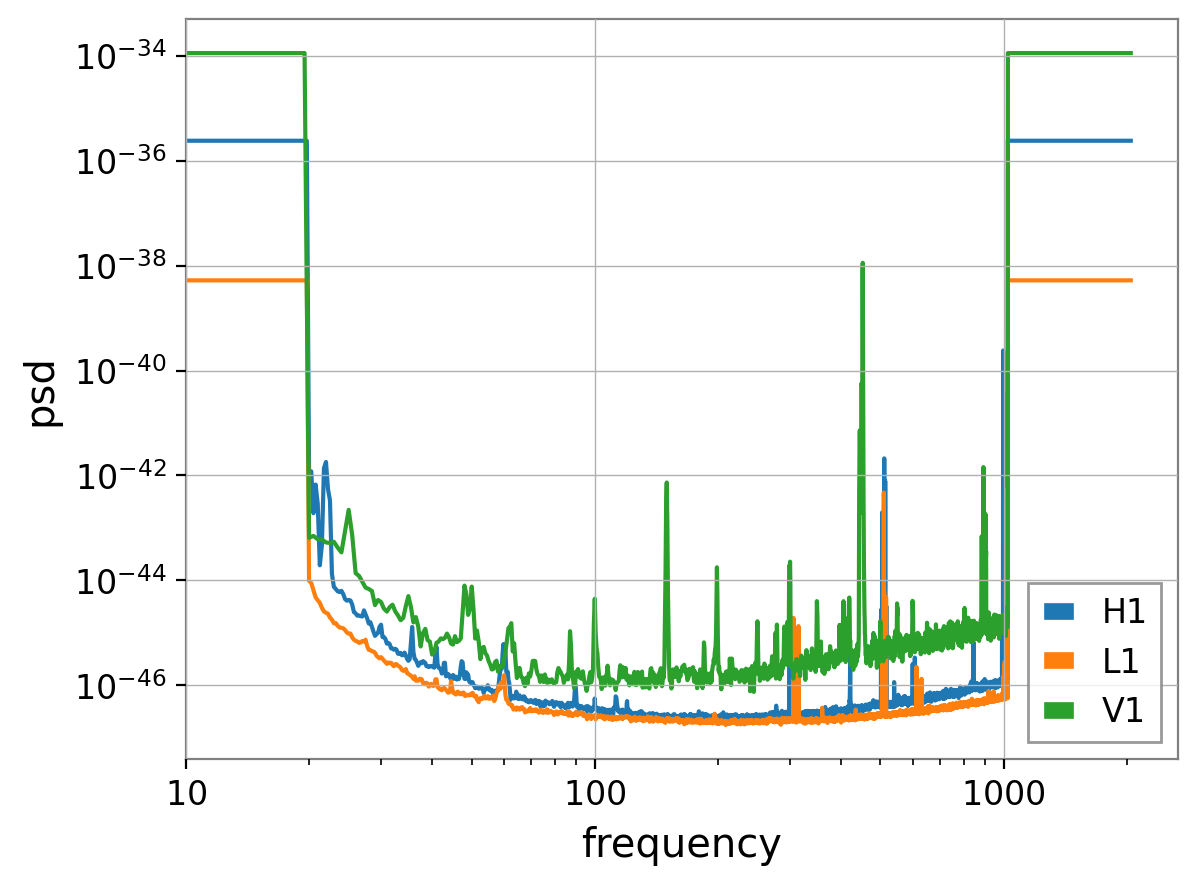

In [3]:
# Plot conditioned PSD
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    freq, psd = lm.conditioned_psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', label=ifo)
plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.xlim(10,)
plt.show()

### Get injection

In [4]:
# get reference parameters
with open('./input/injection.json') as f:
    reference_parameters = json.load(f)

# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    data['runs']['full']['kwargs']['right_ascension'], 
    data['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

In [5]:
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(reference_parameters, data['runs']['full']['args'])
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)
# Whiten injection
injection_dict_whitened = {ifo : utils.whitenData(
    injection_dict[ifo], 
    lm.time_dict[ifo],
    lm.conditioned_psd_dict[ifo][:, 1], 
    lm.conditioned_psd_dict[ifo][:, 0]
) for ifo in lm.ifos}

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot strain

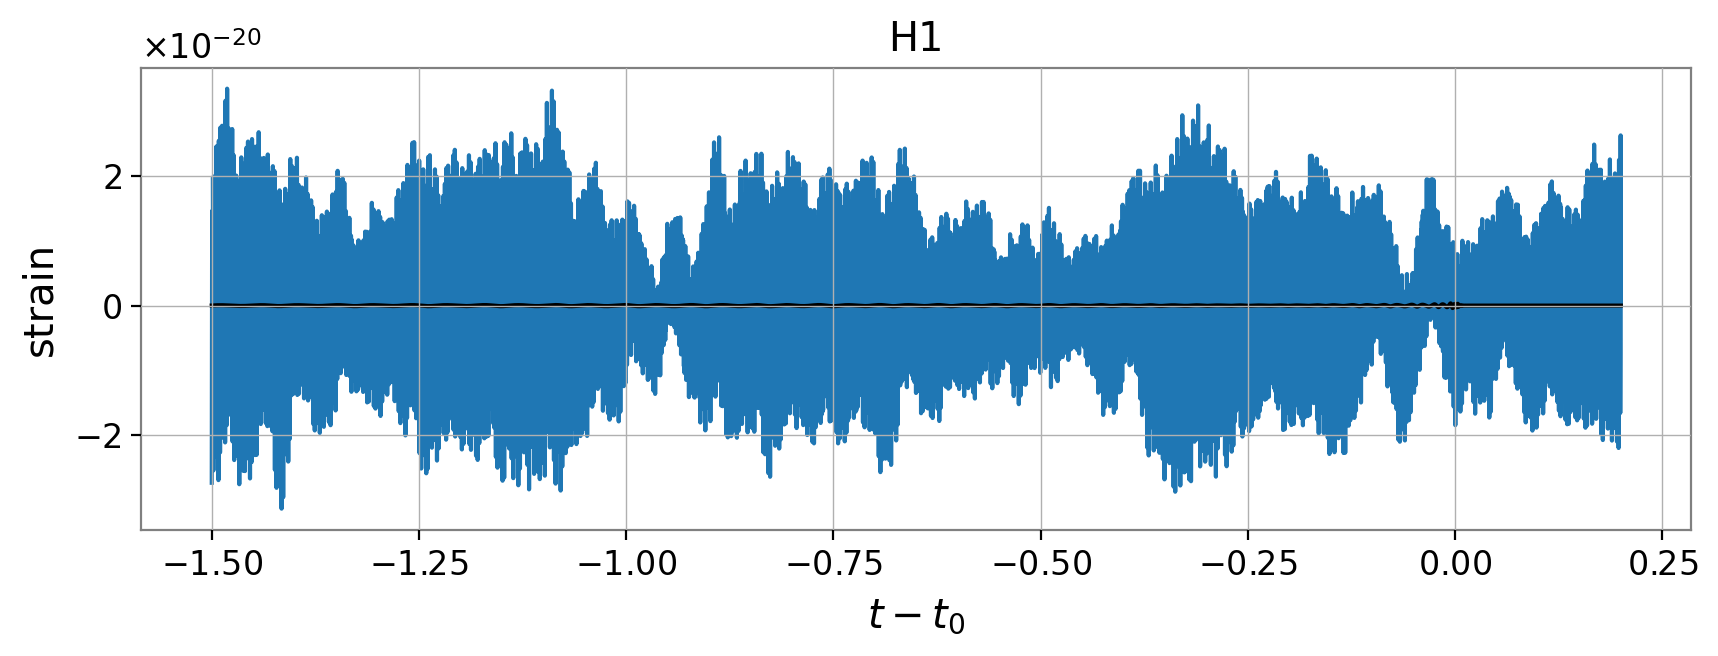

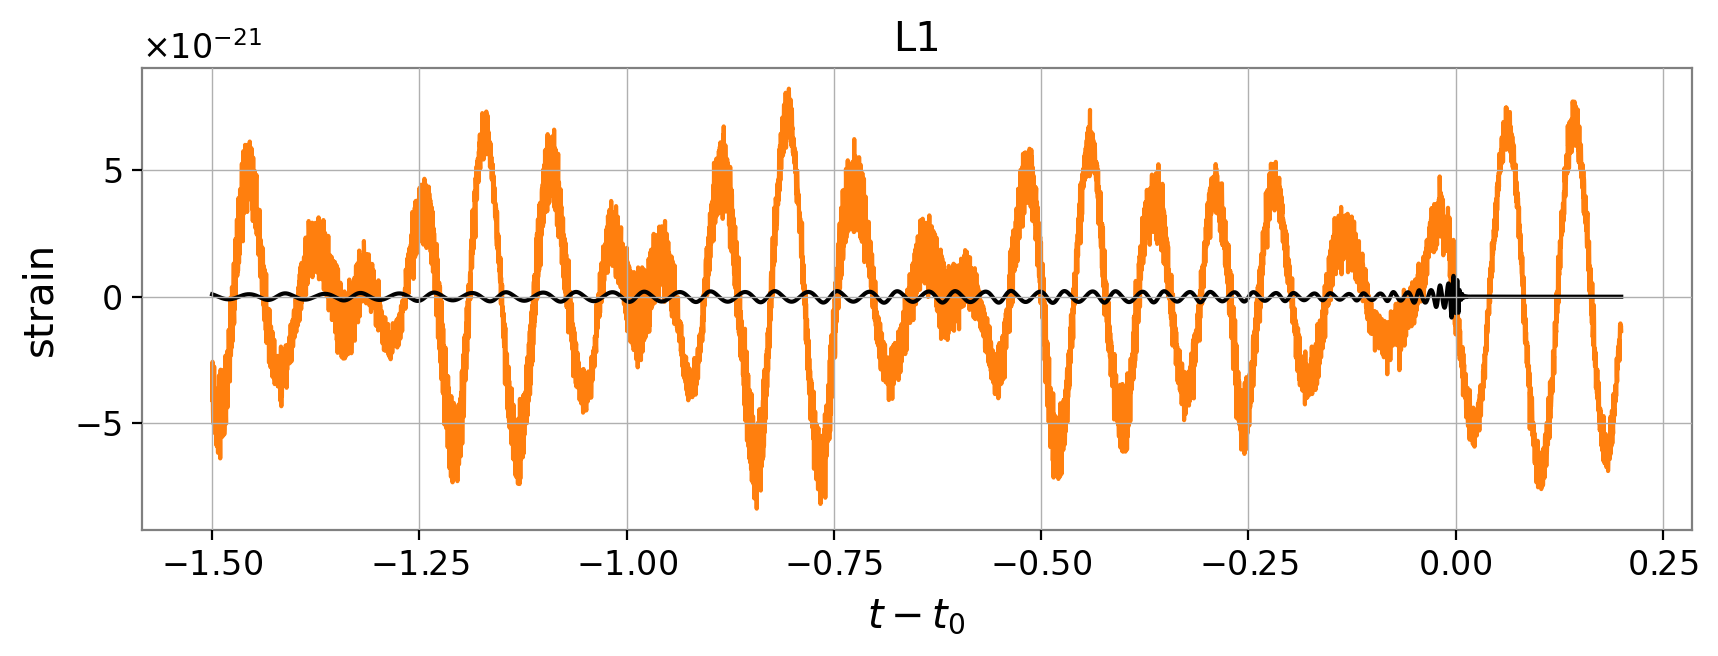

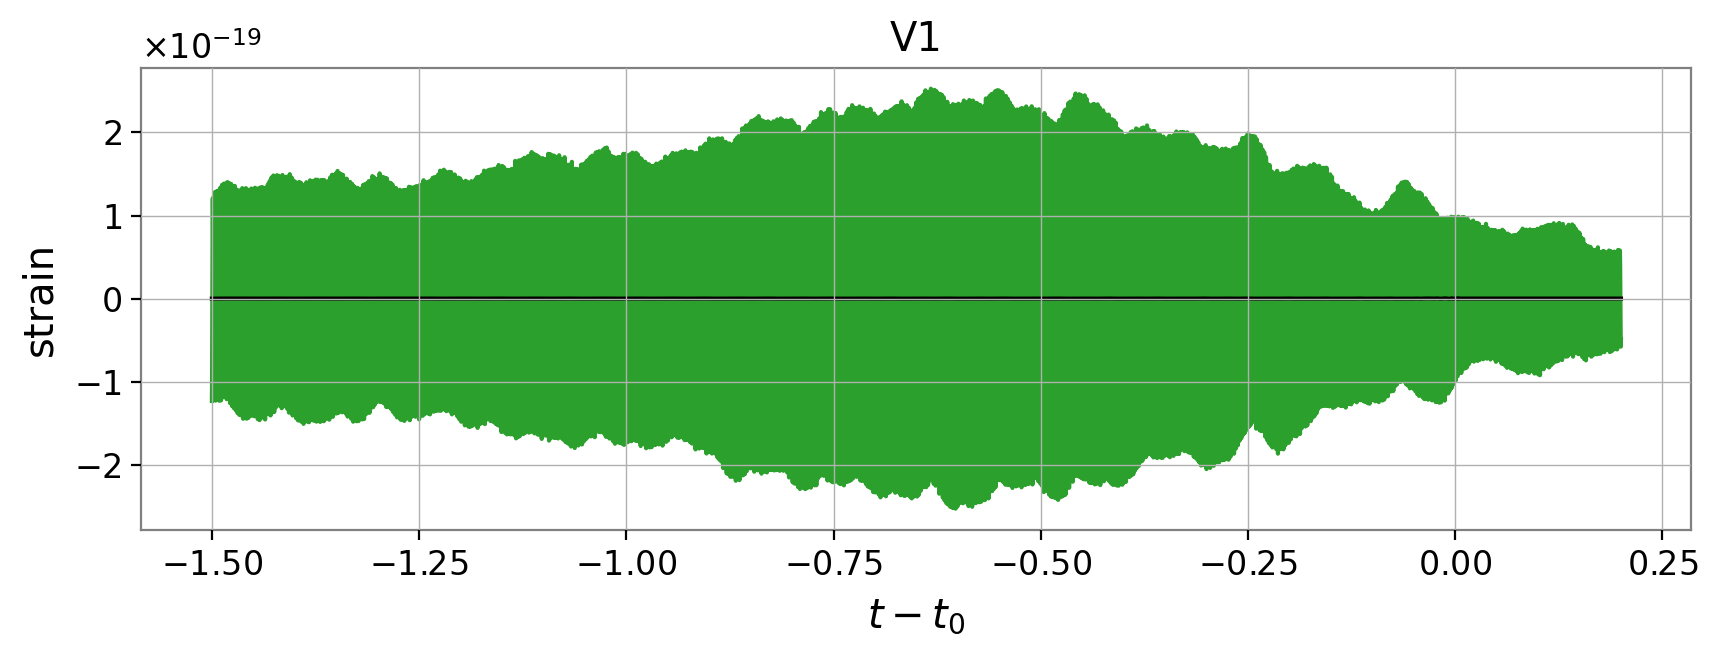

In [6]:
# Colored strain 
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('strain')
    plt.show()

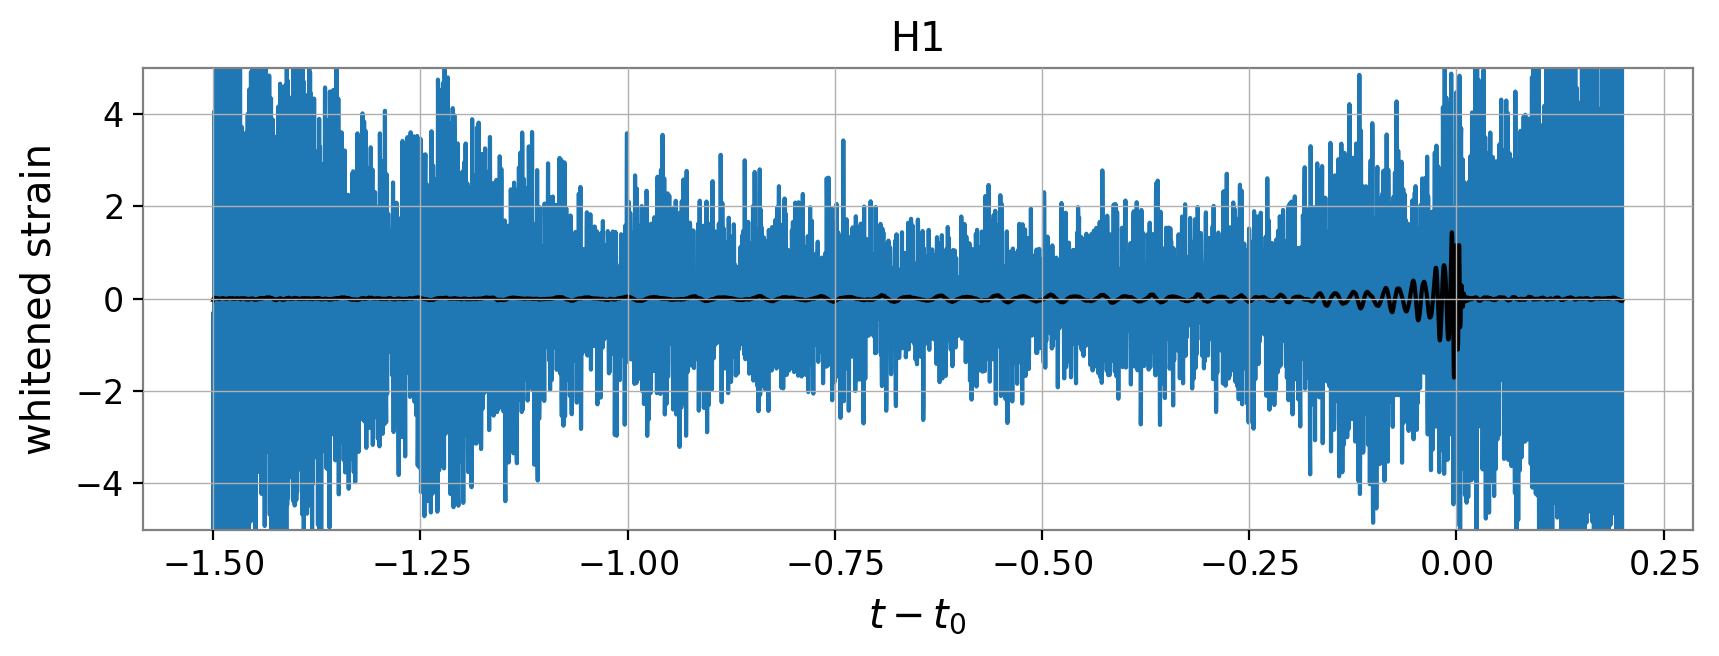

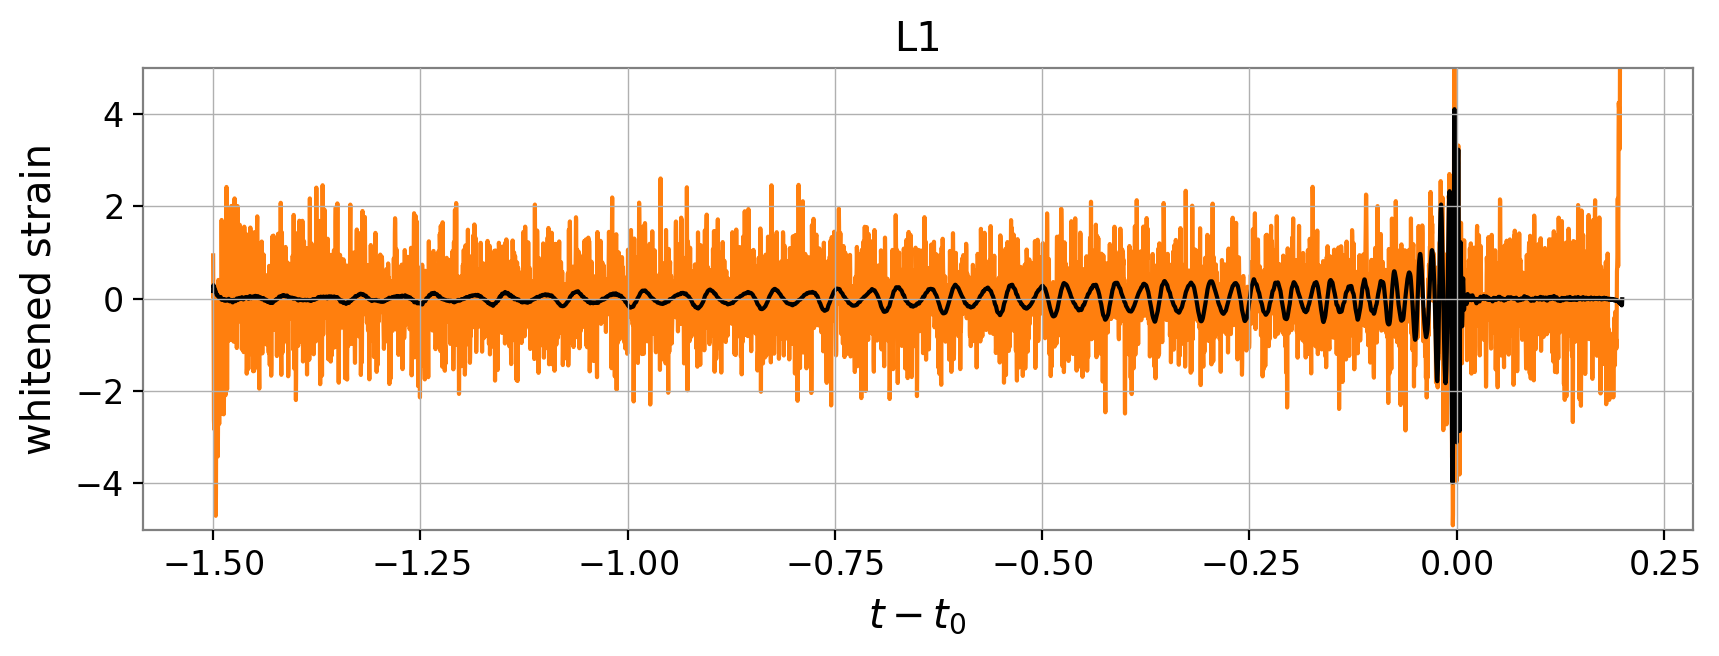

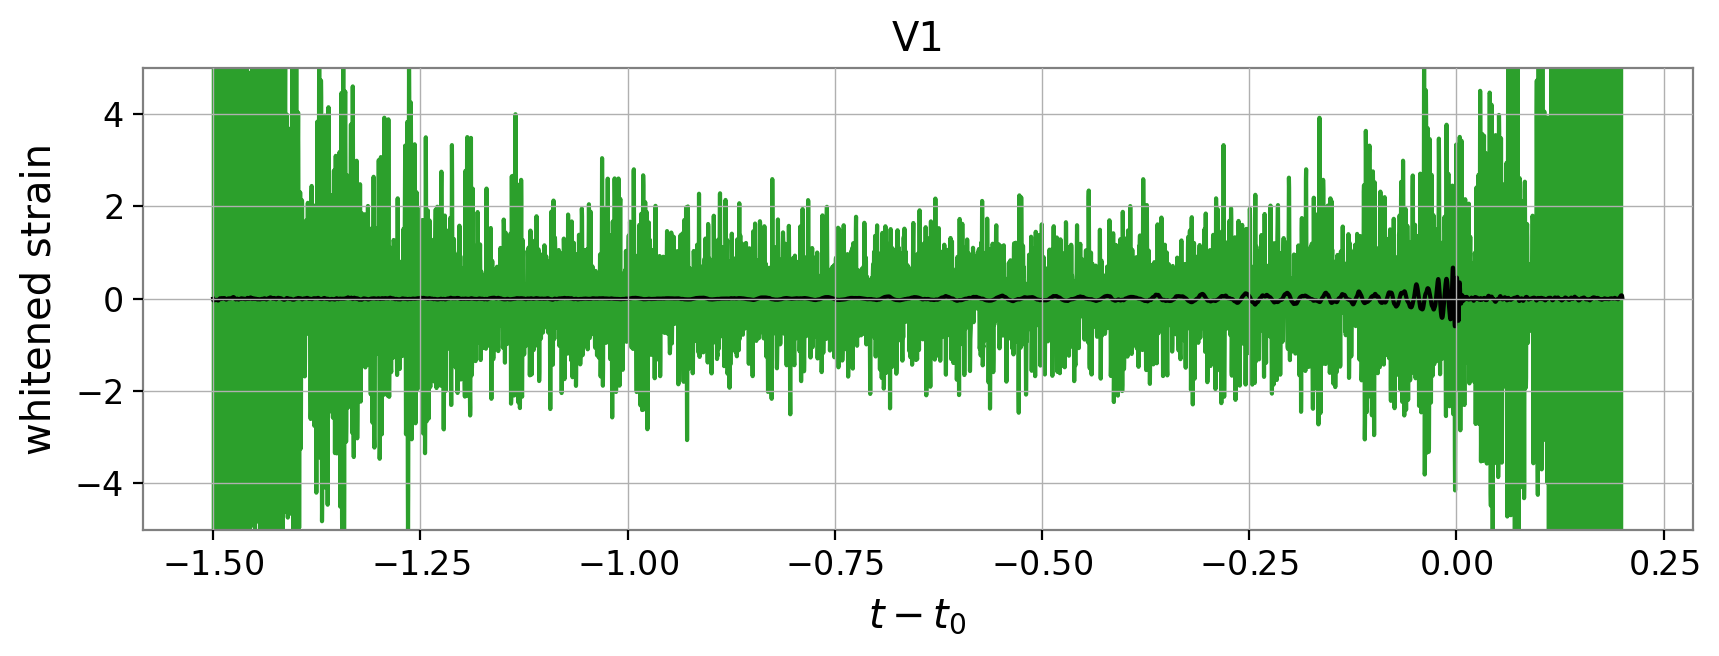

In [7]:
# Whitened strain cropped
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.whitened_data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict_whitened[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    #plt.xlim(-0.1, 0.02)
    plt.ylim(-5,5)
    plt.show()

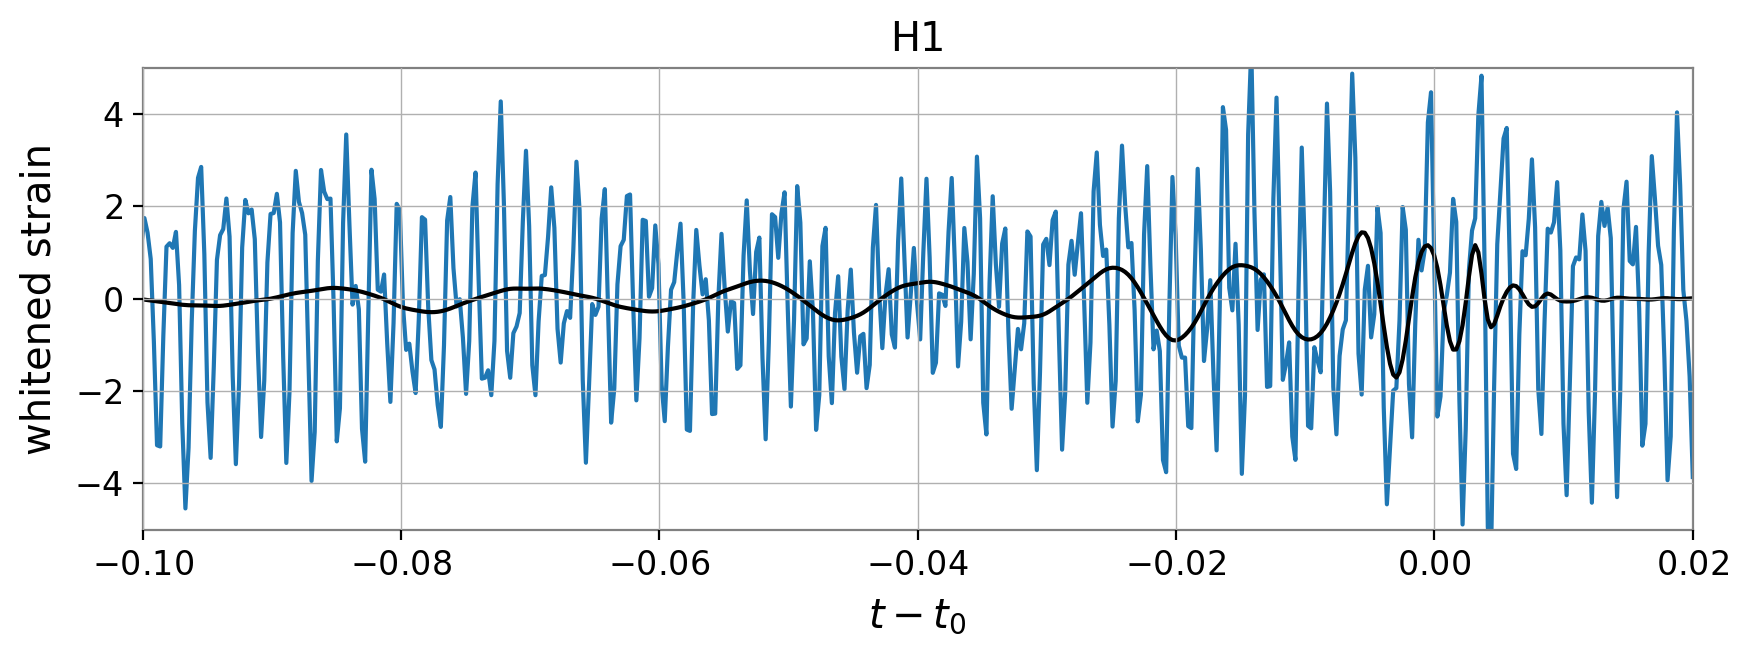

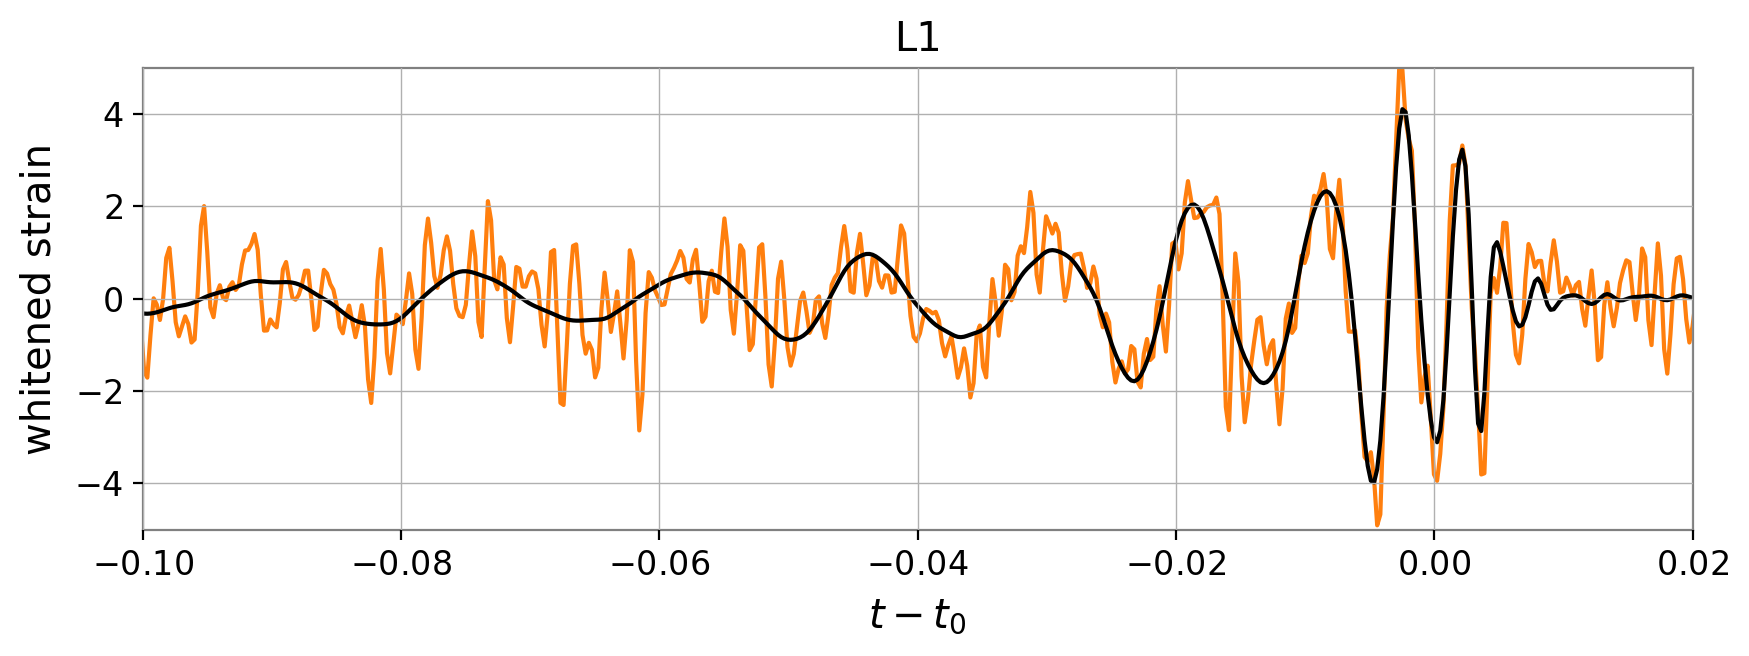

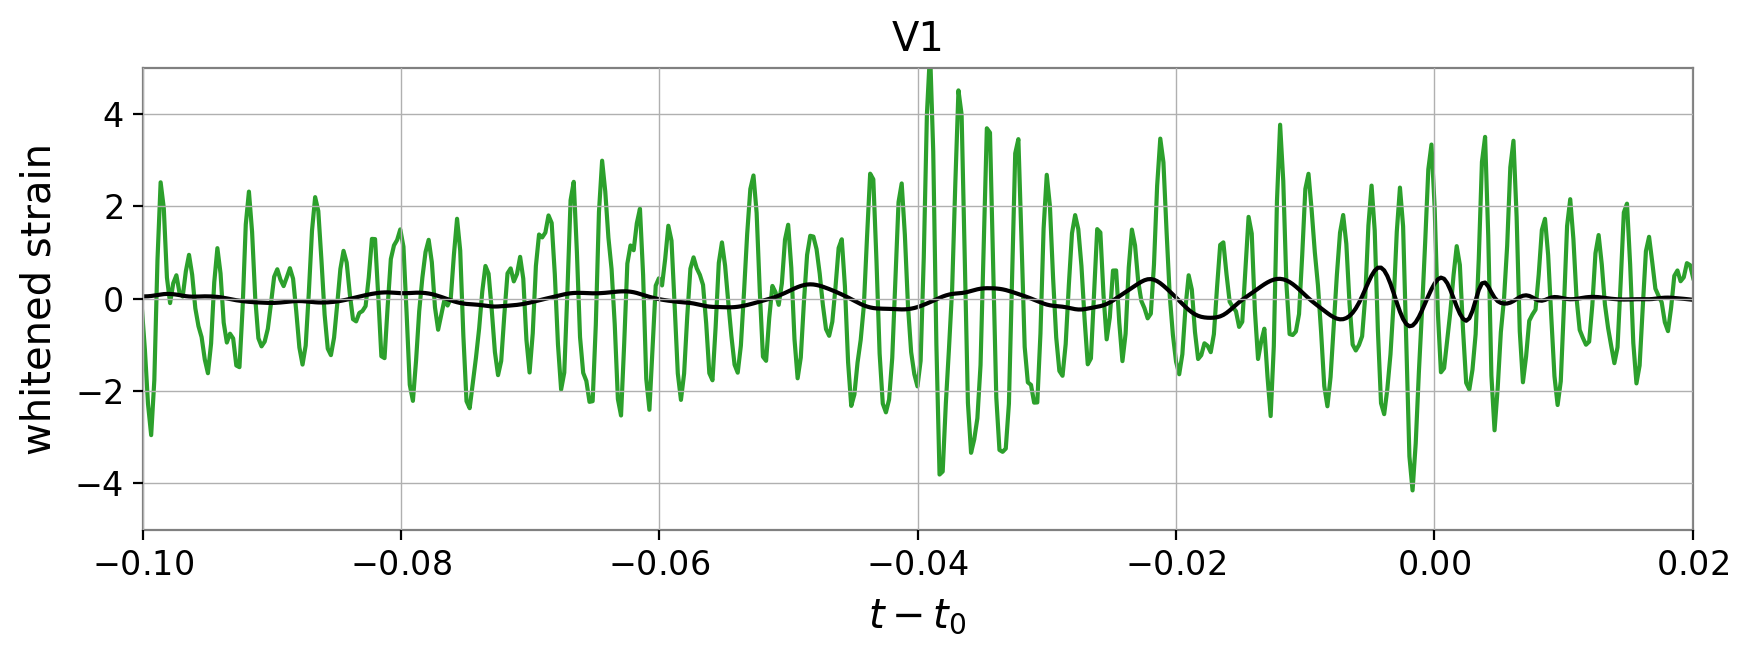

In [8]:
# Whitened strain cropped
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.figure(figsize=(10, 3))
    plt.plot(times, lm.whitened_data_dict[ifo], color=f'C{i}')
    plt.plot(times, injection_dict_whitened[ifo], color='k')
    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.02)
    plt.ylim(-5,5)
    plt.show()

### Cumulative SNR check

In [13]:
times_L1 = lm.time_dict['L1'] - lm.reference_time - dt_dict['L1']
dt = times_L1[1] - times_L1[0]
cum_snr = np.sqrt(np.cumsum(injection_dict_whitened['L1'][::-1]**2))

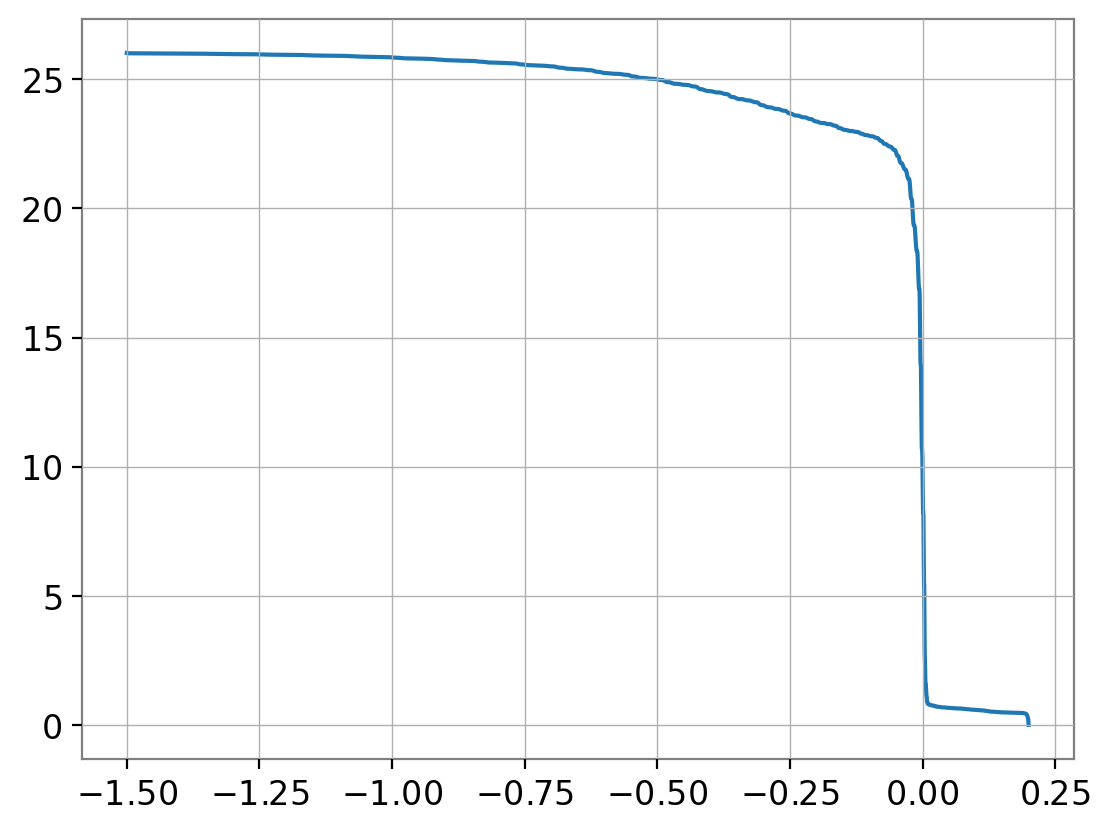

In [14]:
plt.plot(times_L1[::-1], cum_snr)

In [11]:
print('Tstart =', lm.reference_time - 1.5)
print('Tend =', lm.reference_time + 0.2)

Tstart = 1238175798.5930877
Tend = 1238175800.2930877
